In [116]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [117]:
#a handful of sites
sites = ['Depot','a','b', 'c','d']
latlng = ['latitude', 'longitude']
position = pd.read_csv('./coordinates.csv', index_col="City")
flighttime = pd.read_csv('./time.csv', index_col="City")
distance = pd.read_csv('./distance.csv', index_col="City")
position.head(5)

,latitude,longitude
City,,
Depot,28.631276,77.223976
a,28.626685,77.239742
b,28.622655,77.209284
c,28.642655,77.279284
d,28.612654,77.229283


In [118]:
positions = dict( ( city, (position.loc[city, 'longitude'], position.loc[city, 'latitude']) ) for city in sites)
print(positions)

{'Depot': (77.22397579999999, 28.6312756), 'a': (77.23974229999999, 28.6266846), 'b': (77.2092844, 28.622655199999997), 'c': (77.27928440000001, 28.642655199999997), 'd': (77.2292834, 28.6126542)}


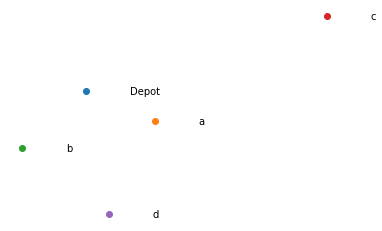

In [119]:
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [120]:
# Actual


# get distanc between cities
distances = dict( ((s1,s2), distance.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)

In [121]:
K = 2 #the number of sales people 

In [122]:
#create the problme
prob=LpProblem("vehicle", LpMinimize)
print(prob)

vehicle:
MINIMIZE
None
VARIABLES



In [123]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1, LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)
print(prob)

vehicle:
MINIMIZE
None
VARIABLES



In [124]:
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost
print(prob)

vehicle:
MINIMIZE
1.6235180439213075*x_('Depot',_'a') + 1.72530222080121*x_('Depot',_'b') + 5.553048887456013*x_('Depot',_'c') + 2.1280686193994467*x_('Depot',_'d') + 1.6235180439213075*x_('a',_'Depot') + 3.0117349293502795*x_('a',_'b') + 4.252302709919252*x_('a',_'c') + 1.8612131984637736*x_('a',_'d') + 1.72530222080121*x_('b',_'Depot') + 3.0117349293502795*x_('b',_'a') + 7.1946642708802955*x_('b',_'c') + 2.2480547215194093*x_('b',_'d') + 5.553048887456013*x_('c',_'Depot') + 4.252302709919252*x_('c',_'a') + 7.1946642708802955*x_('c',_'b') + 5.9128554832895945*x_('c',_'d') + 2.1280686193994467*x_('d',_'Depot') + 1.8612131984637736*x_('d',_'a') + 2.2480547215194093*x_('d',_'b') + 5.9128554832895945*x_('d',_'c') + 0.0
VARIABLES
0 <= x_('Depot',_'a') <= 1 Integer
0 <= x_('Depot',_'b') <= 1 Integer
0 <= x_('Depot',_'c') <= 1 Integer
0 <= x_('Depot',_'d') <= 1 Integer
0 <= x_('a',_'Depot') <= 1 Integer
0 <= x_('a',_'b') <= 1 Integer
0 <= x_('a',_'c') <= 1 Integer
0 <= x_('a',_'d') <= 1 Inte

In [125]:
#constraints
for k in sites:
    cap = 1 if k != 'b' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'b' and j!= 'b') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

Solve it!

In [126]:
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

CPU times: user 5.58 ms, sys: 4.89 ms, total: 10.5 ms
Wall time: 107 ms
Optimal


In [127]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [128]:
tours = get_next_site('b')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='b':
        t.append(get_next_site(t[-1][1])[-1])

The optimal route:

In [129]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['b']))

b -> Depot -> d -> b
b -> c -> a -> b


Calculate total time:

In [130]:
totalTime = 0;
for t in tours:
    time = 0
    for i in range(0, len(t)):
        time += flighttime.loc[t[i][0], t[i][1]]
#         print(flighttime.loc[t[i][0], t[i][1]])
#     print(time)
    if time > totalTime:
        totalTime = time
print(totalTime)

1445.8701910149825


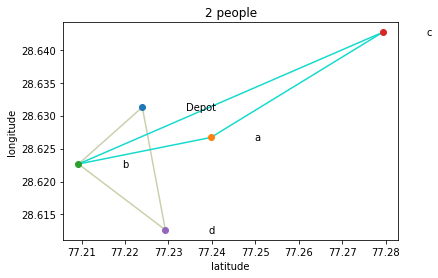

In [131]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
# plt.gca().axis('off')
plt.show()

In [132]:
print('Longest time spent:', totalTime, '(min)')
print('Total distance:', value(prob.objective), '(km)')

Longest time spent: 1445.8701910149825 (min)
Total distance: 20.560127471869894 (km)
